# G3 Processing

This file contains code to view and load G3 files produced by ``g3_packager``.

Since G3 files will mostly be stored on the CCAT Control Computer (in ``/media/player1/blast2020fc1/blasttng_g3``),
it is useful to run this notebook in a Jupyter server on the control computer, then to use SSH tunneling to interact with
the Jupyter notebook through the client's browser. This minimizes the tedious process of saving and transferring data that is needed
for anything other than text output (e.g. Matplotlib plots).


## How to Set Up

Run these commands on the desired client machine.
For this walkthrough, it assumed that the client is already on the CCAT [tailnet](https://tailscale.com/).

1. SSH into the control computer. Follow instructions to authenticate if needed.
    ```
    ssh player1@cube
    ```
2. Enter the project repository on the remote machine
    ```
    cd ~/map_making_jonah/blasttng-to-g3
    ```
3. Set up ``PYTHONPATH`` to fix possible import issues (optional)
    ```
    export PYTHONPATH=$PYTHONPATH:$PWD
    ```
4. Activate the virtual environment
    ```
    source .venv/bin/activate
    ```
5. Start the Jupyter server as a module. Running it this way will ensure the virtual environment is used rather than the global python installation.
    ```
    python3 -m jupyter notebook --no-browser --port 8888
    ```
6. Next, copy the URL that appears in the output (e.g. http://localhost:8888/tree?token=placeholder123456). Return to the terminal on your client machine for the following commands. It may be useful to do this in a new terminal. This will forward the port 8888 on the client to the localhost of the __remote__ control computer at port 8888.
    ```
    # on local machine (not control computer)
    ssh player1@cube -NL 8888:localhost:8888
    ```
7. Finally paste the link copied earlier into your browser and you should be good to go!

## G3 File Analysis

In [18]:
import so3g
from spt3g import core
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import EarthLocation, SkyCoord
import astropy.units
import os

In [19]:
control_computer_g3_dir = "/media/player1/blast2020fc1/blasttng_g3"
path_to_file = "testing/testfile.g3"
filename = os.path.join(control_computer_g3_dir, path_to_file)

### File Content Overview

In [20]:
class FrameCounter(core.G3Module):
    def __init__(self):
        super(FrameCounter, self).__init__()
        self.previous_type = None
        self.num_repeats = 0
    def Process(self, frame):
        type = frame.type
        if type == self.previous_type:
            self.num_repeats += 1
            print(f"{type} (x{self.num_repeats + 1})", end='\r')
        else:
            print()
            print(f"{type}", end='\r')
            if type == core.G3FrameType.EndProcessing: print()
            self.num_repeats = 0
        self.previous_type = type

In [21]:
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=filename)
pipe.Add(FrameCounter)
pipe.Run()


PipelineInfo
Scan (x355)
EndProcessing


### File Content Full Dump

In [22]:
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=filename)
pipe.Add(core.Dump)
pipe.Run()

Frame (PipelineInfo) [
"04-Apr-2025:00:05:39.180148000" (spt3g.core.G3PipelineInfo) => UNKNOWN VCS branch, local diffs
"04-Apr-2025:16:47:53.014319000" (spt3g.core.G3PipelineInfo) => UNKNOWN VCS branch, local diffs
]
Frame (Scan) [
"alt" (spt3g.core.G3Timestream) => 1428 samples at 473.4 Hz
"az" (spt3g.core.G3Timestream) => 1428 samples at 473.4 Hz
"data" (so3g.G3SuperTimestream) => G3SuperTimestream(762, 1428)
"el" (spt3g.core.G3Timestream) => 1428 samples at 473.4 Hz
"lat" (spt3g.core.G3Timestream) => 1428 samples at 473.4 Hz
"lon" (spt3g.core.G3Timestream) => 1428 samples at 473.4 Hz
"time" (spt3g.core.G3Time) => 04-Apr-2025:00:05:39.172783000
]
Frame (Scan) [
"alt" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"az" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"data" (so3g.G3SuperTimestream) => G3SuperTimestream(762, 1428)
"el" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"lat" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"lon" (spt3g.core.G3Timest

### Scan Frame Analysis

In [23]:
class FirstFrameGrabber:
    """Stores the first frame of a given type"""
    def __init__(self, frame_type: core.G3FrameType=None):
        self.frame_type = frame_type if frame_type is not None else core.G3FrameType.Scan
        self.first_frame = None
    def __call__(self, frame):
        if self.first_frame is not None:
            # already found the frame
            return
        if frame.type == self.frame_type:
            self.first_frame = frame
            print(f"Found the first frame with type: {self.frame_type}!")
            print(f"The frame is now stored in {self}'s first_frame attribute.")
            return
class LastFrameGrabber:
    """Grabs the last frame of a given type"""
    def __init__(self, frame_type: core.G3FrameType=None):
        self.frame_type = frame_type if frame_type is not None else core.G3FrameType.Scan
        self.last_frame = None
    def __call__(self, frame):
        if frame.type == self.frame_type:
            self.last_frame = frame
            return
        if frame.type == core.G3FrameType.EndProcessing:
            print(f"Found the last frame with type: {self.frame_type}!")
            print(f"The frame is now stored in {self}'s last_frame attribute.")

In [24]:
first_scan_grabber = FirstFrameGrabber(core.G3FrameType.Scan)
last_scan_grabber = LastFrameGrabber(core.G3FrameType.Scan)

pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=filename)
pipe.Add(first_scan_grabber)
pipe.Add(last_scan_grabber)
pipe.Run()

first_scan_frame = first_scan_grabber.first_frame
last_scan_frame = last_scan_grabber.last_frame

print("\nFirst Scan Frame: ", first_scan_frame)
print("\nLast Scan Frame: ", last_scan_frame)

Found the first frame with type: Scan!
The frame is now stored in <__main__.FirstFrameGrabber object at 0x7fe9abbc5c90>'s first_frame attribute.
Found the last frame with type: Scan!
The frame is now stored in <__main__.LastFrameGrabber object at 0x7fe9abbc5660>'s last_frame attribute.

First Scan Frame:  Frame (Scan) [
"alt" (spt3g.core.G3Timestream) => 1428 samples at 473.4 Hz
"az" (spt3g.core.G3Timestream) => 1428 samples at 473.4 Hz
"data" (so3g.G3SuperTimestream) => G3SuperTimestream(762, 1428)
"el" (spt3g.core.G3Timestream) => 1428 samples at 473.4 Hz
"lat" (spt3g.core.G3Timestream) => 1428 samples at 473.4 Hz
"lon" (spt3g.core.G3Timestream) => 1428 samples at 473.4 Hz
"time" (spt3g.core.G3Time) => 04-Apr-2025:00:05:39.172783000
]

Last Scan Frame:  Frame (Scan) [
"alt" (spt3g.core.G3Timestream) => 1233 samples at 472.9 Hz
"az" (spt3g.core.G3Timestream) => 1233 samples at 472.9 Hz
"data" (so3g.G3SuperTimestream) => G3SuperTimestream(762, 1233)
"el" (spt3g.core.G3Timestream) => 12

In [27]:
def add_radec(frame, az: str="az", el: str="el", lat: str="lat", lon: str="lon", alt: str="alt", data: str="data",
             ra: str="ra", dec: str="dec"):
    """Use astropy coordinate transformations to convert az/el --> ra/dec.

    Keyword arguments indicate keys in the scan frame for inputs/outputs
    Requires lat/lon/alt to determine the telescope location as an input to astropy.coordinates.SkyCoord
    """
    if frame.type != core.G3FrameType.Scan:
        return
    
    az_deg = np.array(frame[az]) / core.G3Units.deg
    el_deg = np.array(frame[el]) / core.G3Units.deg
    lat_deg = np.array(frame[lat]) / core.G3Units.deg
    lon_deg = np.array(frame[lon]) / core.G3Units.deg
    alt_m = np.array(frame[alt]) / core.G3Units.m

    unix_times = np.array(frame[data].times) / core.G3Units.s
    times = astropy.time.Time(unix_times, format="unix")

    blasttng_loc = EarthLocation(lat=lat_deg, lon=lon_deg, height=alt_m)
    sky_coords = SkyCoord(alt=el_deg*astropy.units.deg,
                                              az=az_deg*astropy.units.deg,
                                              obstime=times,
                                              frame='altaz',
                                              location=blasttng_loc)
    t_i = frame[data].times[0]
    t_f = frame[data].times[-1]
    
    ra_ts = core.G3Timestream(sky_coords.icrs.ra.deg * core.G3Units.deg)
    ra_ts.start = t_i
    ra_ts.stop = t_f
    frame[ra] = ra_ts

    dec_ts = core.G3Timestream(sky_coords.icrs.dec.deg * core.G3Units.deg)
    dec_ts.start = t_i
    dec_ts.stop = t_f
    frame[dec] = dec_ts
    


In [28]:
radec_file = os.path.join(control_computer_g3_dir, "testing/add_radec.g3")

pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=filename)
pipe.Add(add_radec)
pipe.Add(core.Dump)
pipe.Add(core.G3Writer, filename=radec_file)
pipe.Run(profile=True)

Frame (PipelineInfo) [
"04-Apr-2025:00:05:39.180148000" (spt3g.core.G3PipelineInfo) => UNKNOWN VCS branch, local diffs
"04-Apr-2025:16:48:36.756061000" (spt3g.core.G3PipelineInfo) => UNKNOWN VCS branch, local diffs
]
Frame (Scan) [
"alt" (spt3g.core.G3Timestream) => 1428 samples at 473.4 Hz
"az" (spt3g.core.G3Timestream) => 1428 samples at 473.4 Hz
"data" (so3g.G3SuperTimestream) => G3SuperTimestream(762, 1428)
"dec" (spt3g.core.G3Timestream) => 1428 samples at 473.4 Hz
"el" (spt3g.core.G3Timestream) => 1428 samples at 473.4 Hz
"lat" (spt3g.core.G3Timestream) => 1428 samples at 473.4 Hz
"lon" (spt3g.core.G3Timestream) => 1428 samples at 473.4 Hz
"ra" (spt3g.core.G3Timestream) => 1428 samples at 473.4 Hz
"time" (spt3g.core.G3Time) => 04-Apr-2025:00:05:39.172783000
]
Frame (Scan) [
"alt" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"az" (spt3g.core.G3Timestream) => 1428 samples at 473.0 Hz
"data" (so3g.G3SuperTimestream) => G3SuperTimestream(762, 1428)
"dec" (spt3g.core.G3Timest

In [32]:
def plot_ra_dec(frame):
    # skip any frame that doesn't contain the right key
    if "ra" not in frame or "dec" not in frame:
        return

    # plot coordinates in real units
    plt.plot(frame["ra"] / core.G3Units.deg, frame["dec"] / core.G3Units.deg)

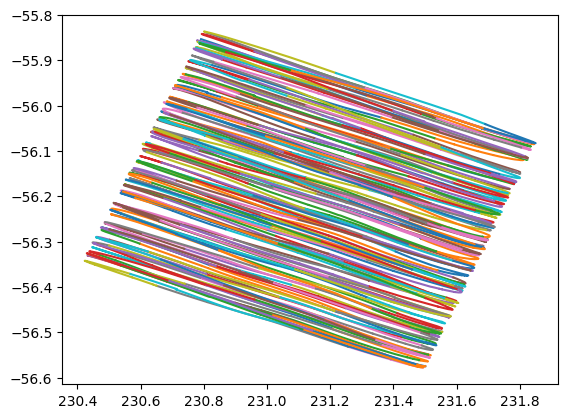

In [33]:
pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=radec_file)
pipe.Add(plot_ra_dec)
pipe.Run()